# Rede LSTM para previsão de Fechamento de uma Ação


## Importando Bibliotecas necessarias para Deep Learning e Mercado Financeiro

In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout




## Download dos Dados e visualização do dataset

In [27]:
# Baixar dados
ticker = 'AAPL'
df = yf.download(ticker, start="2018-01-01", end="2023-12-31")
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [28]:
df.head()

Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,39.933986,40.436212,39.722768,40.426823,102223600
2018-01-03,40.490187,40.964251,40.356418,40.419781,118071600
2018-01-04,40.492539,40.710798,40.384586,40.607536,89738400
2018-01-05,40.703747,41.156687,40.612220,41.069855,94640000
2018-01-08,40.917320,41.213022,40.818749,40.917320,82271200


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2018-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Open, AAPL)    1509 non-null   float64
 1   (High, AAPL)    1509 non-null   float64
 2   (Low, AAPL)     1509 non-null   float64
 3   (Close, AAPL)   1509 non-null   float64
 4   (Volume, AAPL)  1509 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.7 KB


## Normalização dos dados

In [30]:
# Escalador geral para features
scaler_full = MinMaxScaler()
df_scaled = pd.DataFrame(scaler_full.fit_transform(df), columns=df.columns, index=df.index)

# Escalador dedicado para o target
scaler_target = MinMaxScaler()
df_scaled['Close'] = scaler_target.fit_transform(df[['Close']])


## Criando sequencias temporais multivariaveis

In [31]:
def create_multivariate_sequences(dataframe, window_size=60, target_column='Close'):
    data = dataframe.values
    target_index = dataframe.columns.get_loc(target_column)
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i, target_index])
    return np.array(X), np.array(y)



In [32]:
window_size = 60
X, y = create_multivariate_sequences(df_scaled, window_size=window_size, target_column='Close')


## Dividndo os dados em Treino e Teste

In [33]:
# Dividir treino/teste
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Criando modelo LSTM Muti variaveis

In [34]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

## Compilando e Treinando o Modelo

In [36]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0346
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0025
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0022
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0022
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0021
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0024
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0024
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0020
Epoch 9/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0019
Epoch 10/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0021
Epoch 11/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - loss: 0.0017
Epoch 12/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0023
Epoch 13/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0022
Epoch 14/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0018
Epoch 15/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.001

## Plot das Previsões

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


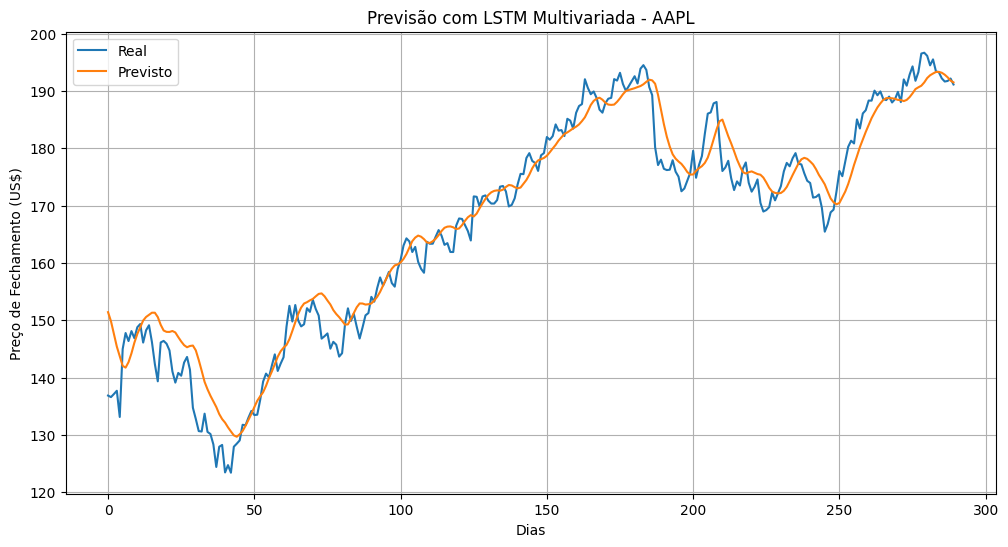

In [37]:
# Prever
y_pred_scaled = model.predict(X_test)
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Plotar
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Real')
plt.plot(y_pred, label='Previsto')
plt.title(f'Previsão com LSTM Multivariada - {ticker}')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento (US$)')
plt.legend()
plt.grid(True)
plt.show()


## Prever na Realidade

In [38]:
def prever_proximo_valor_multivariado(df_original, model, window_size, scaler_full, scaler_target):
    df_recent = df_original[-window_size:]
    df_scaled_recent = scaler_full.transform(df_recent)
    entrada = df_scaled_recent.reshape((1, window_size, df_scaled_recent.shape[1]))

    pred_scaled = model.predict(entrada)

    return scaler_target.inverse_transform(pred_scaled)[0, 0]


In [39]:
previsao_proximo_dia = prever_proximo_valor_multivariado(df, model, window_size, scaler_full, scaler_target)
print(f"📅 Previsão para o próximo dia: US$ {previsao_proximo_dia:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
📅 Previsão para o próximo dia: US$ 191.18


In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Converter previsões e valores reais em arrays unidimensionais
y_pred_flat = y_pred.flatten()
y_real_flat = y_test_rescaled.flatten()

# 2. Calcular direções (1 = subida, 0 = descida ou igual)
def calcular_direcao(series):
    return (np.diff(series) > 0).astype(int)

direcao_real = calcular_direcao(y_real_flat)
direcao_pred = calcular_direcao(y_pred_flat)




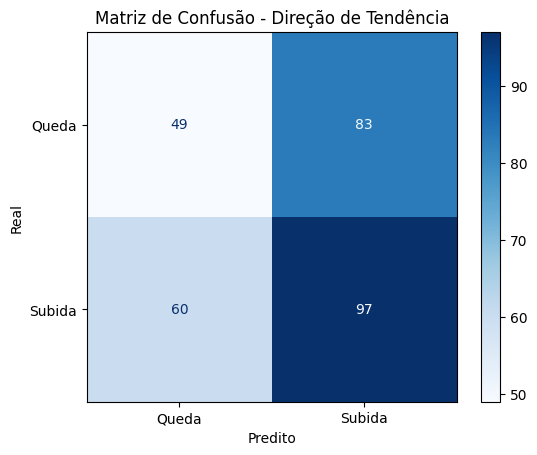

In [41]:
# 3. Calcular matriz de confusão
cm = confusion_matrix(direcao_real, direcao_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Queda", "Subida"])

# 4. Exibir
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - Direção de Tendência")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.grid(False)
plt.show()

In [42]:
# Acurácia de direção: % de vezes em que a predição acertou a direção do movimento
acertos = np.sum(direcao_real == direcao_pred)
total = len(direcao_real)
acuracia_direcao = acertos / total

print(f"✅ Acurácia de direção: {acuracia_direcao * 100:.2f}% ({acertos}/{total})")


✅ Acurácia de direção: 50.52% (146/289)


Na teoria, temoos um modelo vencedor -> Accuracia > 50%

## ✅ 2. **Gráfico com Setas de Tendência**

As **tendências reais** e **preditas** em um mesmo gráfico. Usaremos setas verticais com cores:

* 🔵 Azul para tendência **real**
* 🔴 Vermelho para tendência **predita**



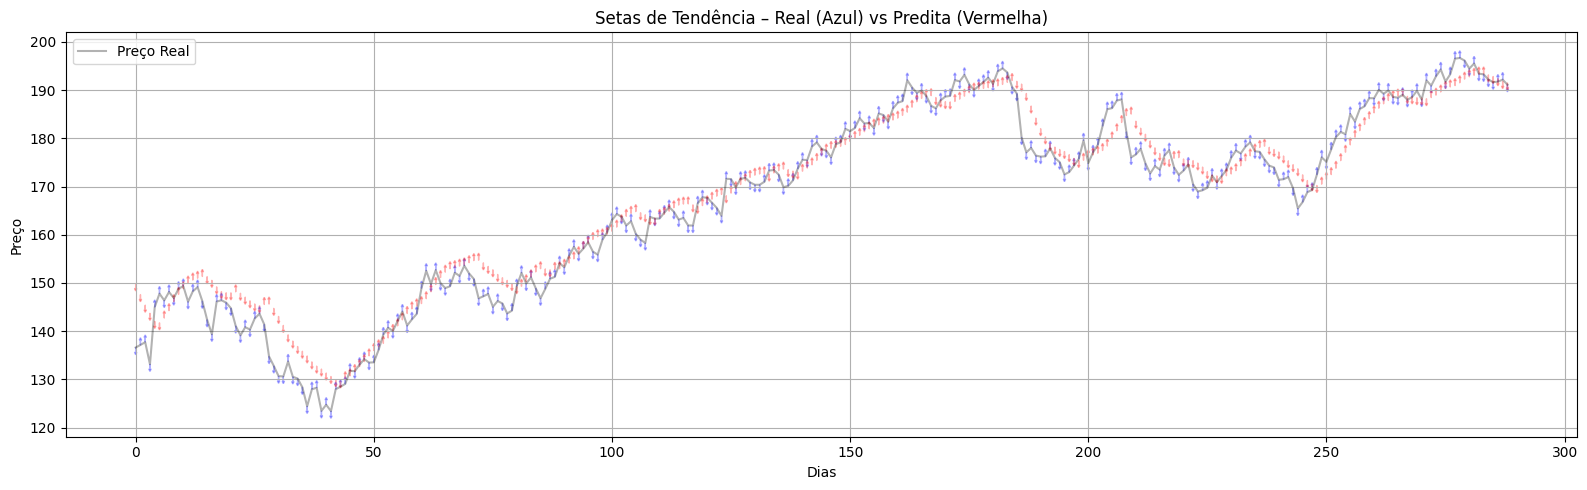

In [43]:
plt.figure(figsize=(16, 5))
dias = np.arange(len(direcao_real))

# Plot base da ação real
plt.plot(y_real_flat[1:], label='Preço Real', color='black', alpha=0.3)

# Setas de tendência real
for i, direcao in enumerate(direcao_real):
    cor = 'blue' if direcao == 1 else 'blue'
    dy = 1.0 if direcao == 1 else -1.0
    plt.arrow(i, y_real_flat[i+1], 0, dy, color=cor, head_width=0.5, head_length=0.5, alpha=0.3)

# Setas de tendência predita
for i, direcao in enumerate(direcao_pred):
    cor = 'red' if direcao == 1 else 'red'
    dy = 1.0 if direcao == 1 else -1.0
    plt.arrow(i, y_pred_flat[i+1], 0, dy, color=cor, head_width=0.5, head_length=0.5, alpha=0.3)

plt.title("Setas de Tendência – Real (Azul) vs Predita (Vermelha)")
plt.xlabel("Dias")
plt.ylabel("Preço")
plt.grid(True)
plt.legend(["Preço Real"])
plt.tight_layout()
plt.show()
